In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Silence TensorFlow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras import regularizers, layers

In [2]:
batch_size = 64
MODEL_DIR = './models'
FLOAT_MODEL = 'float_model.h5'
QAUNT_MODEL = 'quantized_model.h5'

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print('Training data: {}. {}'.format(x_train.shape, y_train.shape))
print('Test data: {}. {}'.format(x_test.shape, y_test.shape))

11493376/11490434 [==============================] - 1s 0us/step
Training data: (60000, 28, 28). (60000,)
Test data: (10000, 28, 28). (10000,)


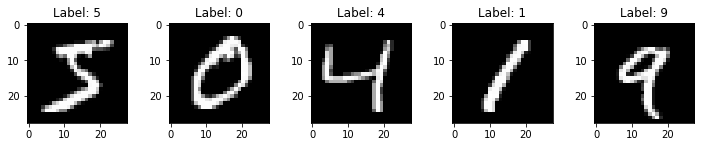

In [4]:
fig, axs = plt.subplots(1, 5, figsize=(10,10))
plt.tight_layout()

for i in range(5):
    axs[i].imshow(x_train[i], 'gray')
    axs[i].set_title('Label: {}'.format(y_train[i]))

In [5]:
# Data Normalization
# 라벨 값을 one-hot-encoding으로 바꿈

x_train = x_train.reshape((60000,28,28,1)).astype('float32') / 255.0
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape((10000,28,28,1)).astype('float32') / 255.0
y_test = keras.utils.to_categorical(y_test)

x_train_flat = x_train.reshape((-1, 784))
x_test_flat = x_test.reshape((-1, 784))

In [6]:
# Create saparated datasets for train,validate,test
train_dataset = tf.data.Dataset.from_tensor_slices((x_train[:50000], y_train[:50000])).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_train[5000:], y_train[5000:])).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

train_dataset_flat = tf.data.Dataset.from_tensor_slices((x_train_flat[:50000], y_train[:50000])).batch(batch_size)
val_dataset_flat = tf.data.Dataset.from_tensor_slices((x_train_flat[5000:], y_train[5000:])).batch(batch_size)
test_dataset_flat = tf.data.Dataset.from_tensor_slices((x_test_flat, y_test)).batch(batch_size)

In [7]:
def customcnn():
    # create a cnn model
    inputs = keras.Input(shape=(28,28,1))
    x = layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1))(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_customcnn_model')
    model.summary()

    # Compile the model"
    optimizer = keras.optimizers.RMSprop(lr=0.001)
    model.compile(optimizer=optimizer, 
            loss="categorical_crossentropy",
            metrics=['accuracy']
            )
    return model

def customFC():
    # create a Fully Connected model
    inputs = keras.Input(shape=(28,28))
    inputs = keras.Input(name='input', shape=(784,))

    x = layers.Dense(300, name='hidden_1', activation='relu')(inputs)
    x = layers.Dense(100, name='hidden_2', activation='relu')(x)
    

    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_customcnn_model')
    model.summary()

    # Compile the model
    optimizer = keras.optimizers.RMSprop(lr=0.001)
    model.compile(optimizer=optimizer, 
            loss="categorical_crossentropy",
            metrics=['accuracy']
            )
    return model

In [8]:
# build cnn model
print("\nCreate custom cnn..")
model = customcnn()


Create custom cnn..
Model: "mnist_customcnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)       

In [9]:
model.summary()

Model: "mnist_customcnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)     

In [10]:
# Train the model for 10 epochs using a dataset
print("\nFit on dataset..")
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)


Fit on dataset..
Epoch 1/10
782/782 [==============================] - 10s 13ms/step - loss: 0.1982 - accuracy: 0.9398 - val_loss: 0.0660 - val_accuracy: 0.9792
Epoch 2/10
782/782 [==============================] - 10s 12ms/step - loss: 0.0526 - accuracy: 0.9842 - val_loss: 0.0376 - val_accuracy: 0.9884
Epoch 3/10
782/782 [==============================] - 10s 13ms/step - loss: 0.0346 - accuracy: 0.9899 - val_loss: 0.0259 - val_accuracy: 0.9921
Epoch 4/10
782/782 [==============================] - 10s 13ms/step - loss: 0.0245 - accuracy: 0.9930 - val_loss: 0.0259 - val_accuracy: 0.9926
Epoch 5/10
782/782 [==============================] - 10s 13ms/step - loss: 0.0187 - accuracy: 0.9948 - val_loss: 0.0241 - val_accuracy: 0.9927
Epoch 6/10
782/782 [==============================] - 10s 12ms/step - loss: 0.0144 - accuracy: 0.9960 - val_loss: 0.0236 - val_accuracy: 0.9932
Epoch 7/10
782/782 [==============================] - 10s 12ms/step - loss: 0.0115 - accuracy: 0.9964 - val_loss: 0.01

Text(0.5, 1.0, 'Training Accuracy / Validation Accuracy')

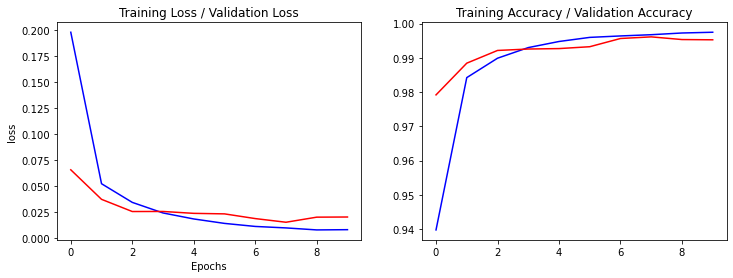

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history.history['loss'], 'b')
axs[0].plot(history.history['val_loss'], 'r')
axs[0].set_title('Training Loss / Validation Loss')
axs[0].set(xlabel='Epochs', ylabel='loss')

axs[1].plot(history.history['accuracy'], 'b')
axs[1].plot(history.history['val_accuracy'], 'r')
axs[1].set_title('Training Accuracy / Validation Accuracy')

In [12]:
# Evaluate model with test data
print("\nEvaluate model on test dataset..")
import time

loss, acc = model.evaluate(test_dataset)  # returns loss and metrics
print("Test Loss: %.3f" % loss)
print("Test Accuracy: %.3f" % acc)


Evaluate model on test dataset..
157/157 [==============================] - 1s 3ms/step - loss: 0.0508 - accuracy: 0.9903
Test Loss: 0.051
Test Accuracy: 0.990


In [13]:
# build cnn model
print("\nCreate custom FC..")
model_FC = customFC()


Create custom FC..
Model: "mnist_customcnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
hidden_1 (Dense)             (None, 300)               235500    
_________________________________________________________________
hidden_2 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Train the model for 10 epochs using a dataset
print("\nFit on dataset..")
history_FC = model_FC.fit(train_dataset_flat, epochs=10, validation_data=val_dataset_flat)


Fit on dataset..
Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2348 - accuracy: 0.9303 - val_loss: 0.1146 - val_accuracy: 0.9655
Epoch 2/10
782/782 [==============================] - 4s 6ms/step - loss: 0.0960 - accuracy: 0.9719 - val_loss: 0.0719 - val_accuracy: 0.9786
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0628 - accuracy: 0.9825 - val_loss: 0.0551 - val_accuracy: 0.9833
Epoch 4/10
782/782 [==============================] - 4s 6ms/step - loss: 0.0448 - accuracy: 0.9877 - val_loss: 0.0522 - val_accuracy: 0.9849
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0343 - accuracy: 0.9902 - val_loss: 0.0546 - val_accuracy: 0.9847
Epoch 6/10
782/782 [==============================] - 4s 6ms/step - loss: 0.0264 - accuracy: 0.9927 - val_loss: 0.0458 - val_accuracy: 0.9875
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0213 - accuracy: 0.9937 - val_loss: 0.0489 - val_accur

Text(0.5, 1.0, 'Training Accuracy / Validation Accuracy')

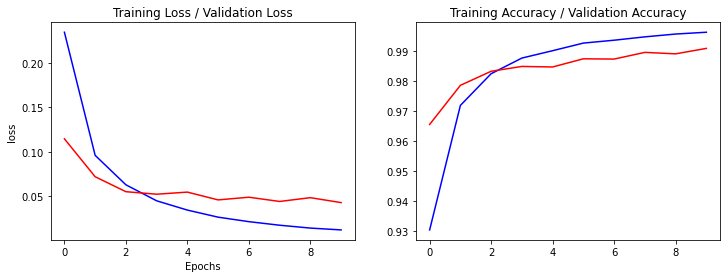

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history_FC.history['loss'], 'b')
axs[0].plot(history_FC.history['val_loss'], 'r')
axs[0].set_title('Training Loss / Validation Loss')
axs[0].set(xlabel='Epochs', ylabel='loss')

axs[1].plot(history_FC.history['accuracy'], 'b')
axs[1].plot(history_FC.history['val_accuracy'], 'r')
axs[1].set_title('Training Accuracy / Validation Accuracy')

In [16]:
# Evaluate model with test data
print("\nEvaluate model on test dataset..")
import time

loss, acc = model_FC.evaluate(test_dataset_flat)  # returns loss and metrics
print("Test Loss: %.3f" % loss)
print("Test Accuracy: %.3f" % acc)


Evaluate model on test dataset..
157/157 [==============================] - 0s 2ms/step - loss: 0.1245 - accuracy: 0.9783
Test Loss: 0.125
Test Accuracy: 0.978


In [17]:
# Save CNN model
path = os.path.join(MODEL_DIR, FLOAT_MODEL)
print("\nSave trained model to{}.".format(path))
model.save(path)


Save trained model to./models/float_model.h5.


## MNIST model quantization

In [18]:
### 32-bit float model

In [19]:
model = tf.keras.models.load_model('./models/float_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
#saving converted model in "converted_model.tflite" file
open("./models/converted_model.tflite", "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmplu9zr704/assets


377116

In [20]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_test).batch(1).take(100):
        yield [input_value]

In [21]:
### 8-bit integer quantization

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
#converter.inference_input_type = tf.uint8
#converter.inference_output_type = tf.uint8

tflite_model_quant_int8 = converter.convert()
#saving converted model in "converted_model.tflite" file
open("./models/converted_quant_model_int8.tflite", "wb").write(tflite_model_quant_int8)

INFO:tensorflow:Assets written to: /tmp/tmpcmgz_gps/assets


INFO:tensorflow:Assets written to: /tmp/tmpcmgz_gps/assets


104400

In [23]:
### 16-bit float quantization

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model_float16 = converter.convert()
#saving converted model in "converted_model.tflite" file
open("./models/converted_quant_model_float16.tflite", "wb").write(tflite_quant_model_float16)

INFO:tensorflow:Assets written to: /tmp/tmpcdiq3dxr/assets


INFO:tensorflow:Assets written to: /tmp/tmpcdiq3dxr/assets


192032

In [25]:
# integer only: 16-bit activations with 8-bit weights (experimental)

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.representative_dataset = representative_data_gen
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
tflite_quant_model_act16_wei_8 = converter.convert()
#saving converted model in "converted_model.tflite" file
open("./models/converted_quant_model_act16_wei_8.tflite", "wb").write(tflite_quant_model_act16_wei_8)

INFO:tensorflow:Assets written to: /tmp/tmp0p7nrxe1/assets


INFO:tensorflow:Assets written to: /tmp/tmp0p7nrxe1/assets


105328

In [27]:
print("32-bit Float model in Mb:", 
      os.path.getsize('./models/converted_model.tflite') / float(2**20))
print("16-bit Float Quantized model in Mb:", 
      os.path.getsize('./models/converted_quant_model_float16.tflite') / float(2**20))
print("Compression ratio:", 
      os.path.getsize('./models/converted_model.tflite')/os.path.getsize('./models/converted_quant_model_float16.tflite'))

32-bit Float model in Mb: 0.3596458435058594
16-bit Float Quantized model in Mb: 0.183135986328125
Compression ratio: 1.9638185302449591


In [28]:
print("32-bit Float model in Mb:", 
      os.path.getsize('./models/converted_model.tflite') / float(2**20))
print("16-bit(A) 8-bit(W) int Quantized model in Mb:", 
      os.path.getsize('./models/converted_quant_model_act16_wei_8.tflite') / float(2**20))
print("Compression ratio:", 
      os.path.getsize('./models/converted_model.tflite')/os.path.getsize('./models/converted_quant_model_act16_wei_8.tflite'))

32-bit Float model in Mb: 0.3596458435058594
16-bit(A) 8-bit(W) int Quantized model in Mb: 0.1004486083984375
Compression ratio: 3.5803964757709252


In [29]:
import tensorflow.keras.models as models
from tensorflow_model_optimization.quantization.keras import vitis_quantize

In [30]:
# Load the floating point trained model
print('Load float model..')
path = os.path.join(MODEL_DIR, FLOAT_MODEL)
print(path)
try:
    float_model = models.load_model(path)
except:
    print('\nError:load float model failed!')

Load float model..
./models/float_model.h5


In [31]:
# get input dimensions of the floating-point model
height = float_model.input_shape[1]
width = float_model.input_shape[2]

In [32]:
# Run vitis-quantization
print('\nRun quantization..')
quantizer = vitis_quantize.VitisQuantizer(float_model)
quantized_model = quantizer.quantize_model(calib_dataset=test_dataset)


Run quantization..
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 1s 61ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
157/157 [==============================] - 3s 19ms/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quantize Adjustment...
[VAI INFO] Post-Quantize Adjustment Done.
[VAI INFO] Quantization Finished.


In [33]:
# Save quantized model
path = os.path.join(MODEL_DIR, QAUNT_MODEL)
quantized_model.save(path)
print('\nSaved quantized model as',path)


Saved quantized model as ./models/quantized_model.h5


In [34]:
path = os.path.join(MODEL_DIR, QAUNT_MODEL)
with vitis_quantize.quantize_scope():
    quantized_model = models.load_model(path, compile=False)

In [35]:
# Compile the model
print('\nCompile model..')
quantized_model.compile(optimizer="rmsprop", 
        loss="categorical_crossentropy",
        metrics=['accuracy']
        )


Compile model..


In [36]:
# Evaluate model with test data
print("\nEvaluate model on test Dataset")
loss, acc = quantized_model.evaluate(test_dataset)  # returns loss and metrics
print("Test Loss: %.3f" % loss)
print("Test Accuracy: %.3f" % acc)


Evaluate model on test Dataset
157/157 [==============================] - 1s 6ms/step - loss: 0.0511 - accuracy: 0.9905
Test Loss: 0.051
Test Accuracy: 0.990


In [37]:
!echo "-----------------------------------------"
!echo "COMPILING MODEL FOR ZCU104.."
!echo "-----------------------------------------"

!vai_c_tensorflow2 \
            --model ./models/quantized_model.h5 \
            --arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU104/arch.json \
            --output_dir ./compiled_model/zcu104 \
            --net_name customcnn

!echo "-----------------------------------------"
!echo "MODEL COMPILED"
!echo "-----------------------------------------"

-----------------------------------------
COMPILING MODEL FOR ZCU104..
-----------------------------------------
**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['./models/quantized_model.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/customcnn_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/home/TA/Experiment1/models/quantized_model.h5
[INFO] keras version: 2.4.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel     :100%|█| 26/26 [00:00<00:00, 5318.83it/s]            
[INFO] dump xmodel: /tmp/customcnn_org.xmodel
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA0_B4096_MAX_BG2
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: function
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA0_B4096_MAX_BG2
[UNILOG][INFO] Graph name: mnist_customcnn_model, 

In [72]:
for w in quantized_model.non_trainable_weights:
    print(w)


quantized_model.summary()
model.summary()

<tf.Variable 'quant_input_1/quant_input_1_min:0' shape=() dtype=float32, numpy=0.0>
<tf.Variable 'quant_input_1/quant_input_1_max:0' shape=() dtype=float32, numpy=1.0>
<tf.Variable 'quant_input_1/quant_input_1_pos:0' shape=() dtype=float32, numpy=6.0>
<tf.Variable 'quant_input_1/optimizer_step:0' shape=() dtype=int32, numpy=-1>
<tf.Variable 'quant_conv2d/optimizer_step:0' shape=() dtype=int32, numpy=-1>
<tf.Variable 'quant_conv2d/kernel_min:0' shape=() dtype=float32, numpy=-0.3831253>
<tf.Variable 'quant_conv2d/kernel_max:0' shape=() dtype=float32, numpy=0.2998602>
<tf.Variable 'quant_conv2d/kernel_pos:0' shape=() dtype=float32, numpy=8.0>
<tf.Variable 'quant_conv2d/bias_min:0' shape=() dtype=float32, numpy=-0.16152509>
<tf.Variable 'quant_conv2d/bias_max:0' shape=() dtype=float32, numpy=0.08685454>
<tf.Variable 'quant_conv2d/bias_pos:0' shape=() dtype=float32, numpy=9.0>
<tf.Variable 'quant_conv2d_relu/optimizer_step:0' shape=() dtype=int32, numpy=-1>
<tf.Variable 'quant_conv2d_relu/p

In [38]:
import time
def TFLiteInference(model_path,x_test,y_test):

    #Step 1. Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    print(tflite_interpreter.get_input_details())
    # Get indexes of input and output layers
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']

    sum_correct=0.0
    sum_time=0.0
    for idx, data in enumerate(zip(x_test,y_test)):
        image=data[0]
        label=data[1]
        image=tf.expand_dims(image, axis=0) #shape will be [1,32,32,3]
        
        s_time=time.time()
        #Step 2. Transform input data
        interpreter.set_tensor(input_index,image)
        #Step 3. Run inference
        interpreter.invoke()
        #Step 4. Interpret output
        pred=interpreter.get_tensor(output_index)
        
        sum_time+=time.time()-s_time
        if np.argmax(pred)== np.argmax(label):
            sum_correct+=1.0
    
    mean_acc=sum_correct / float(idx+1)
    mean_time=sum_time / float(idx+1)

    print(f'Accuracy of TFLite model: {mean_acc}')
    print(f'Inference time of TFLite model: {mean_time}')
    
TFLiteInference(model_path='./models/converted_model.tflite',x_test=x_test,y_test=y_test)
TFLiteInference(model_path='./models/converted_quant_model_float16.tflite',x_test=x_test,y_test=y_test)
TFLiteInference(model_path='./models/converted_quant_model_act16_wei_8.tflite',x_test=x_test,y_test=y_test)
TFLiteInference(model_path='./models/converted_quant_model_int8.tflite',x_test=x_test,y_test=y_test)


NameError: name 'tflite_interpreter' is not defined